# (28751) Eggl orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

In [3]:
body_id = '28751'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
de_kernel = 441

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 1493 observations from the MPC.
	Filtered to 1493 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: GSC
	Unknown star catalog: UNK
	No debiasing needed for 587 observations.
	Debiased 891 observations.
	No bias information for 15 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 1395 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 297 observations.
Read in 273 Gaia observations from gaiafpr
	Filtered to 273 observations that satisfy the time range constraints.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.383			 0.552			 854.306			 0.242
2			 0.383			 0.552			 854.205			 0.242
3			 0.383			 0.552			 854.205			 0.242
Converged without rejecting outliers. Starting outlier rejection now...
4			 0.373			 0.535			 798.118			 0.227
5			 0.373			 0.535			 798.333			 0.227
6			 0.373			 0.535			 798.333			 0.227
Converged after rejecting outliers. Rejected 5 out of 1766 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 6 (of 6):
RMS unweighted: 0.3729988995299711
RMS weighted: 0.534850543515277
chi-squared: 798.3334528316304
reduced chi-squared: 0.22705729602719865
square root of reduced chi-squared: 0.47650529485746396
--------------------------------------------------------------
Solution Time: MJD 57771.000 TDB = 2017-01-18 00:00:00.000 TDB
Solution Observation Arc: 10741.82 days (29.41 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			1.13401656354e-01		2.69371758805e-09		1.13401656909e-01		2.68904178088e-09		+5.54935208896e-10		+0.206
q			2.23466547248e+00		5.19199077579e-09		2.23466547189e+00		5.18486438943e-09		-5.96436677824e-10		-0.115
tp			5.79393028847e+04		3.10452200867e-06		5.79393028847e+04		3.10374009524e-06		+3.49173205905e-08		+0.011
om			2.76278186645e+02		2.72949155643e-06		2.76278186786e+02		2.72881816968e-0

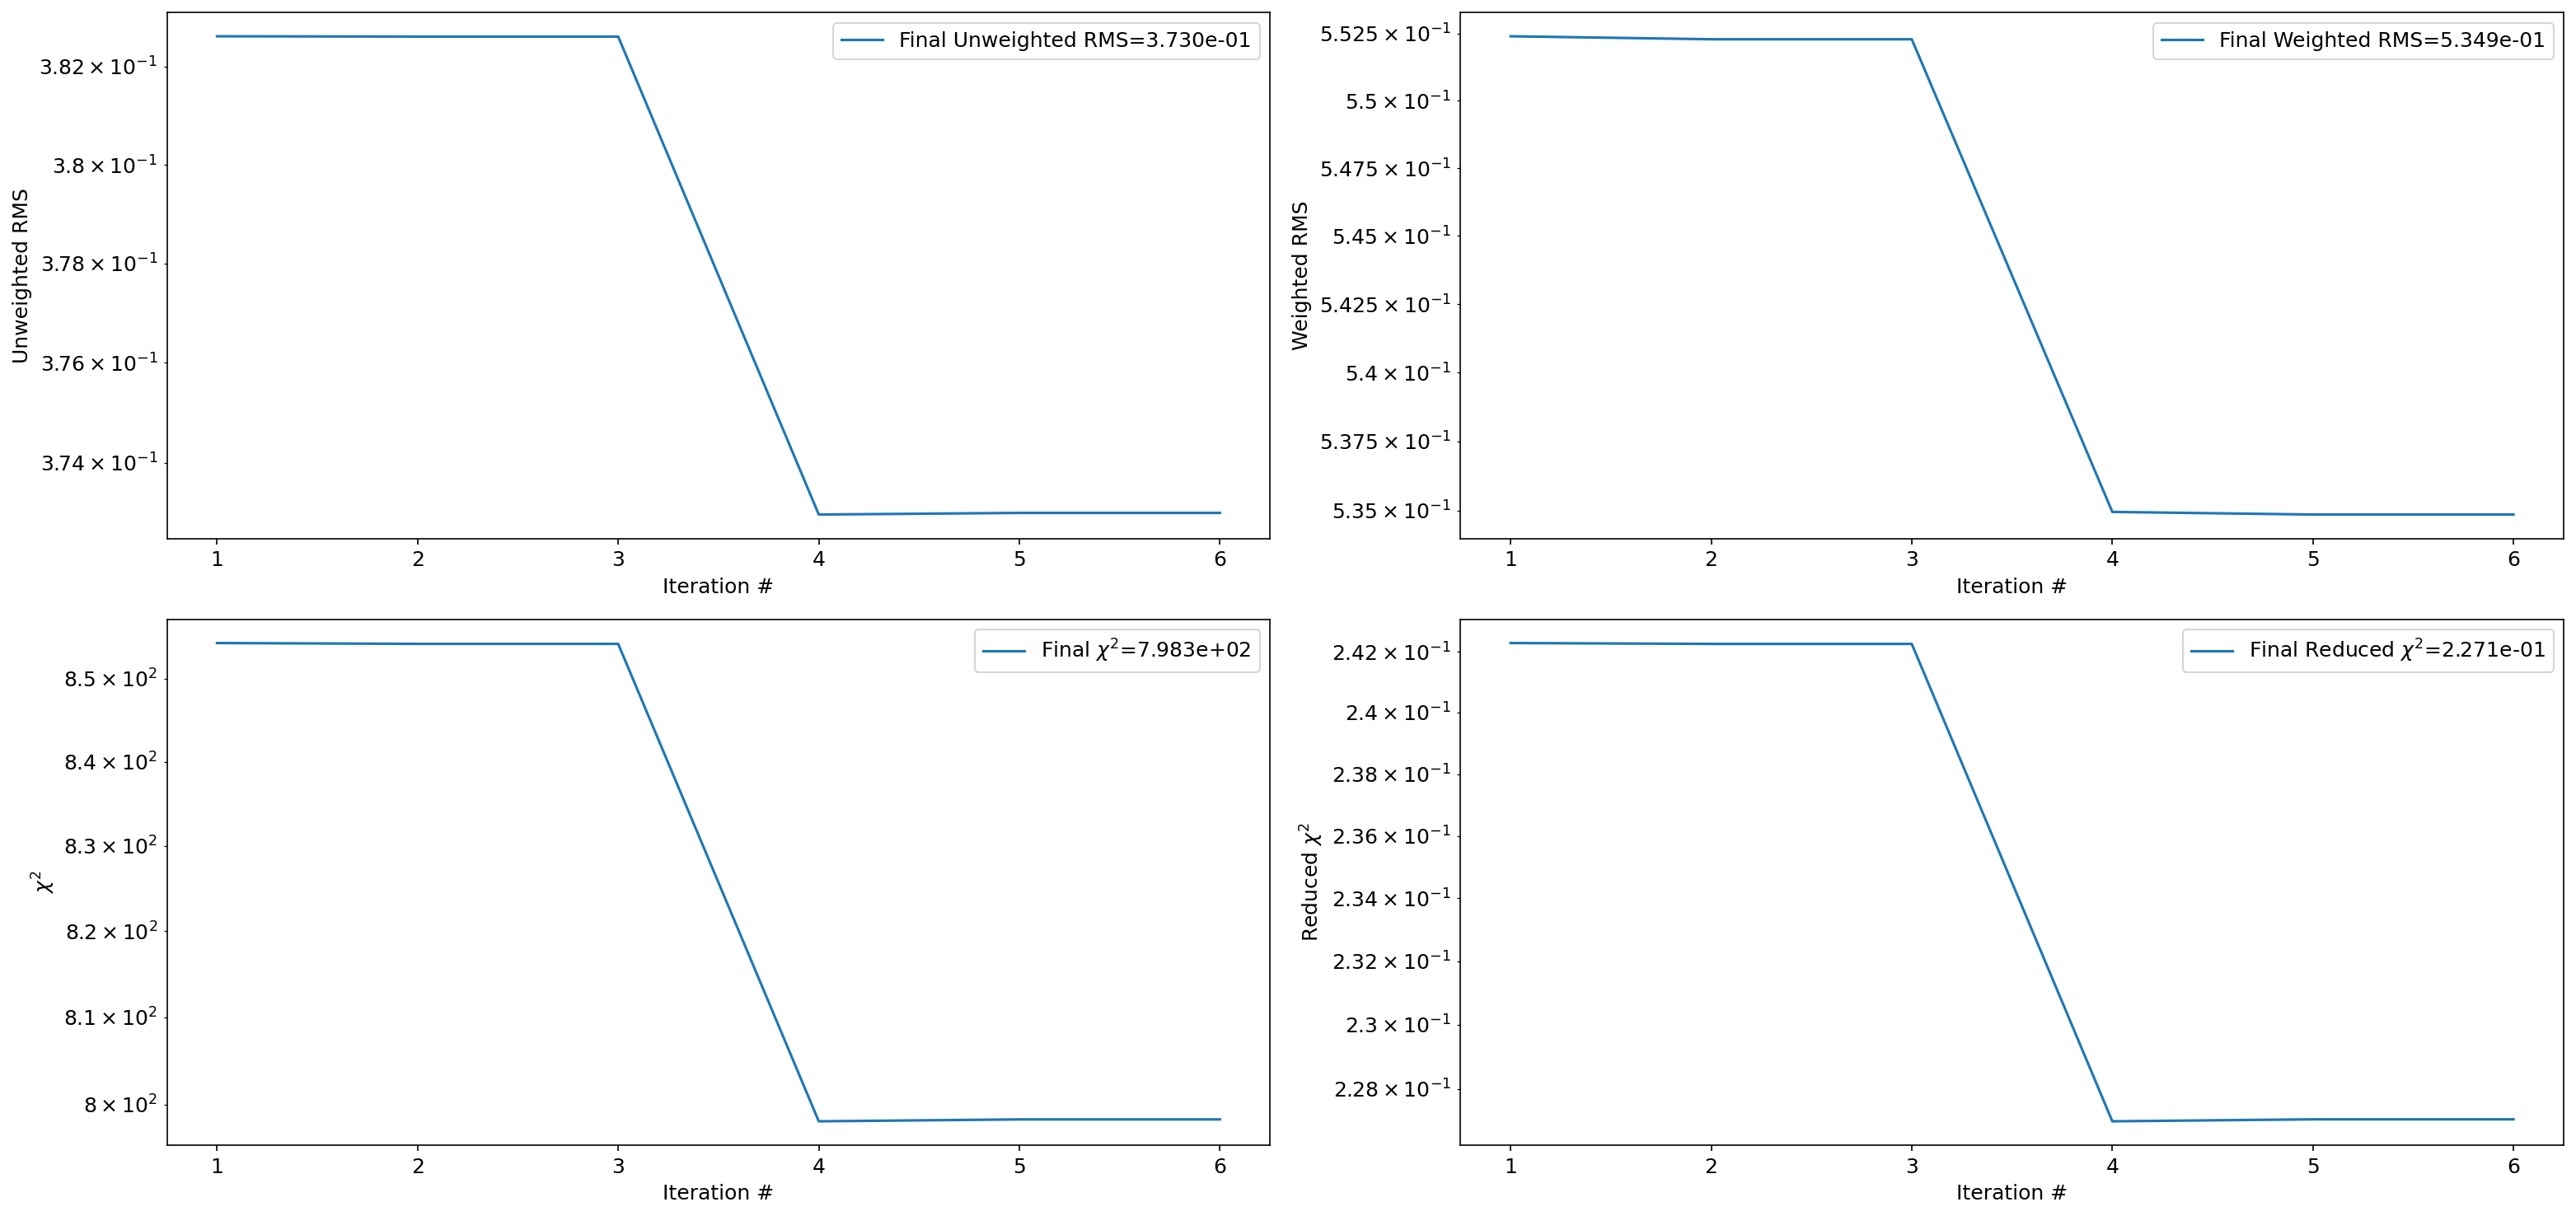

In [8]:
fit_sim.plot_summary(auto_close=True)

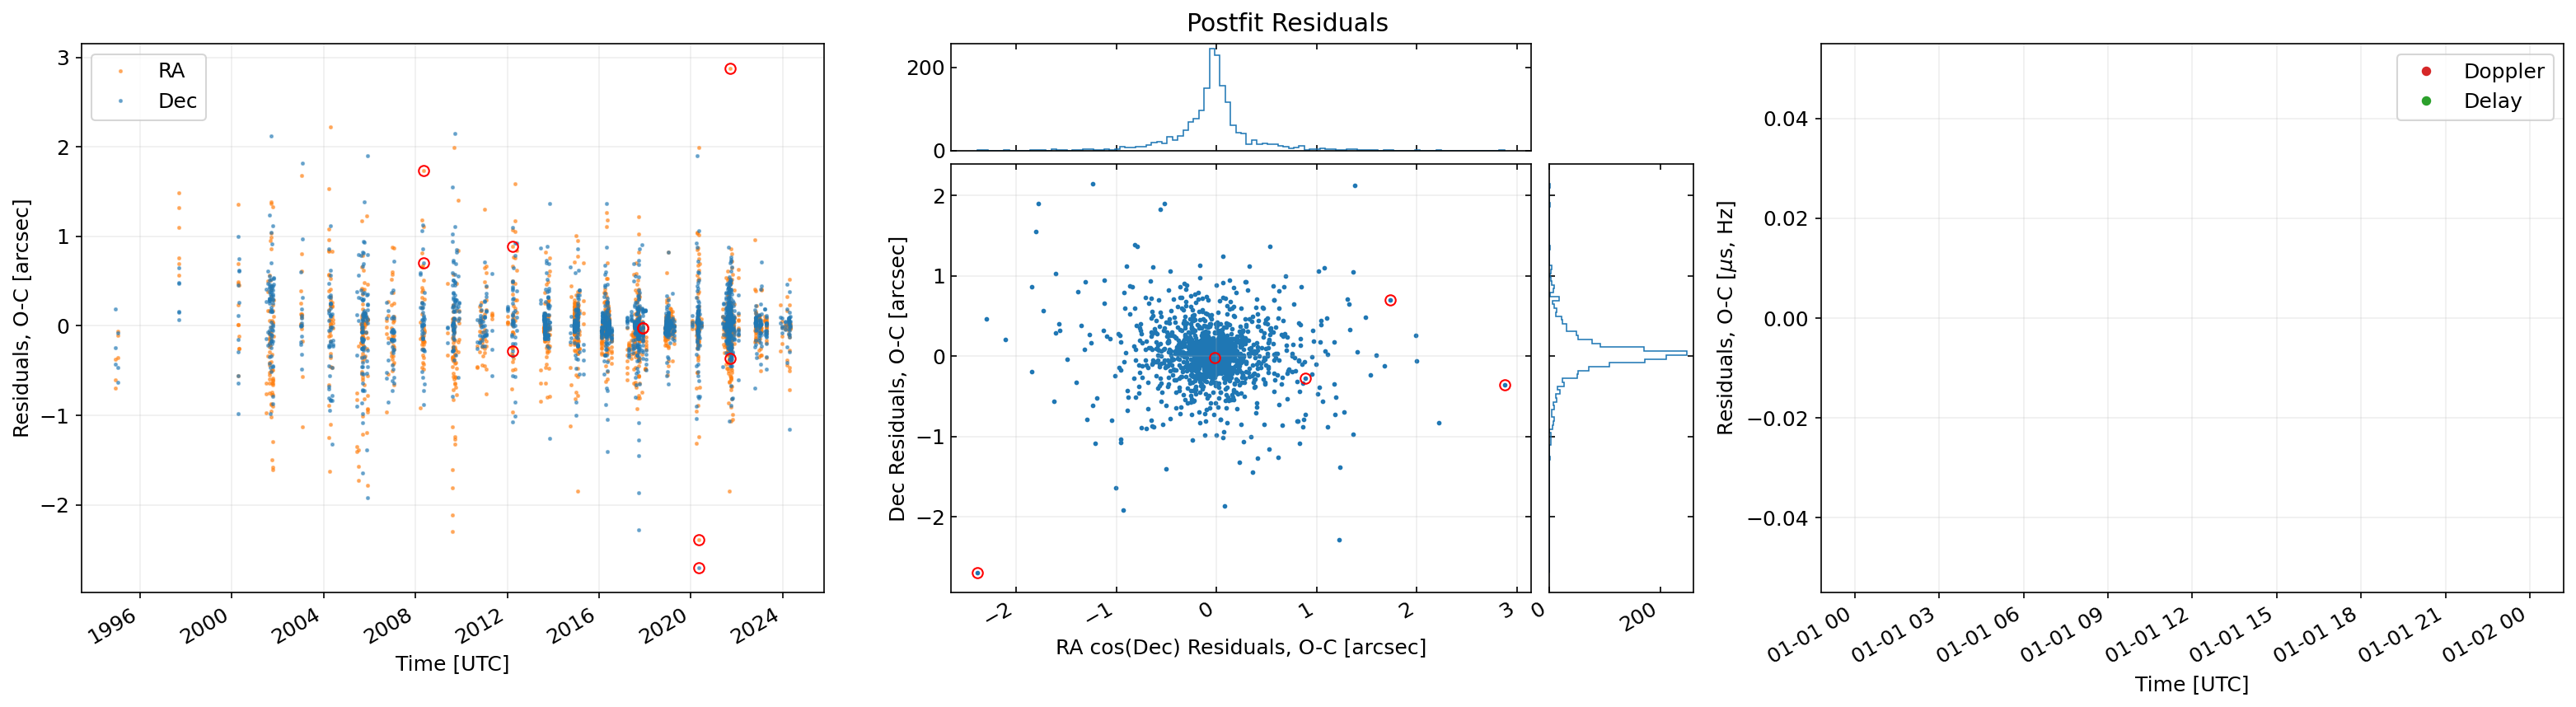

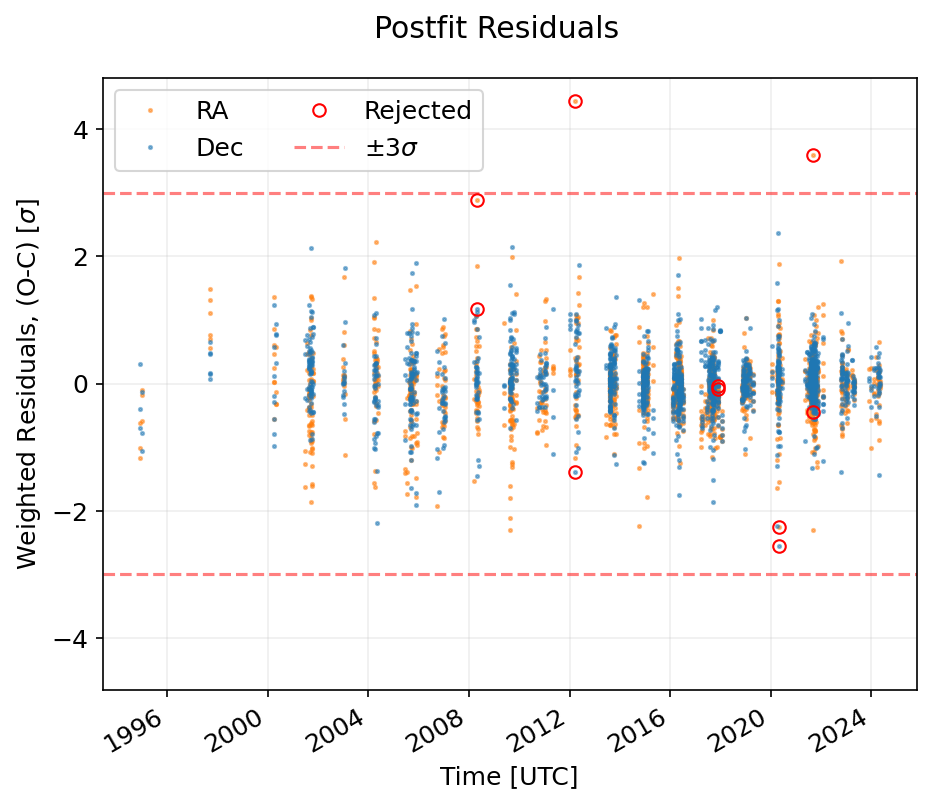

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.26
Mahalonobis distance between GRSS and JPL solution: 0.26
Bhattacharya distance between JPL and GRSS solution: 0.0000
Bhattacharya coefficient between JPL and GRSS solution: 1.0000


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90